# Working with TRIS Data # 
This notebook attempts to visualize the TRIS data, replicate some of their methods, and look at disk/halo models that are consistent with the galactic component of their data

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner
import glob


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

import ModelDefinitions as MD
import LogProb as LP
import const as const
import TRIS_vals as tris
from const import *
from TRIS_vals import *
import importlib
importlib.reload(LP);
importlib.reload(MD);
importlib.reload(const);
importlib.reload(tris);

### Plot Data ###

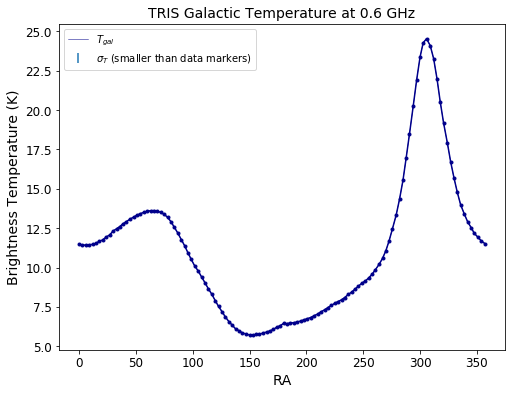

In [45]:
# plot total brightness and Tgal for both frequencies

fig = plt.figure(figsize=(8,6))
# fig.subplots_adjust(hspace=0.4, wspace=0.25, top=0.92)

# plt.subplot(1, 2, 1)
#plt.plot(TRIS_ra[0.6e9], TRIS_Tb[0.6e9], label='$T_{sky}$')
plt.plot(TRIS_ra[0.6e9], TRIS_Tgal[0.6e9],'darkblue', marker='.')
plt.plot(TRIS_ra[0.6e9], TRIS_Tgal[0.6e9],'darkblue', linestyle='-', linewidth='0.5', label=('$T_{gal}$'))
plt.errorbar(TRIS_ra[0.6e9], TRIS_Tgal[0.6e9], TRIS_Tbsig[0.6e9], linestyle='None', label=('$\sigma_{T}$ (smaller than data markers)'))
plt.title('TRIS Galactic Temperature at 0.6 GHz', fontsize=14)
plt.xlabel('RA', fontsize=14)
plt.ylabel('Brightness Temperature (K)', fontsize=14)
plt.legend();

# plt.subplot(1, 2, 2)
# #plt.plot(TRIS_ra[0.82e9], TRIS_Tb[0.82e9], label='$T_{sky}$')
# plt.plot(TRIS_ra[0.82e9], TRIS_Tgal[0.82e9],'g-', label=('$T_{gal}$'))
# plt.title('TRIS Galactic Temperature at 0.82 GHz', fontsize=12)
# plt.xlabel('RA', fontsize=12)
# plt.ylabel('Brightness Temperature (K)', fontsize=12)
# #plt.legend();

plt.savefig('/home/nitikayad96/GradSchool/Classes/Ge117/Ge117_Tgal.png', bbox_inches='tight')

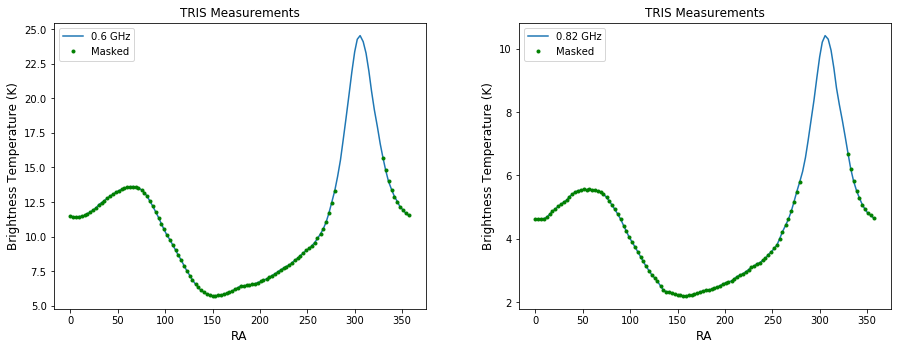

In [40]:
### Show mask of Cygnus X regions ###

fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.25, top=0.92)

plt.subplot(1, 2, 1)
plt.plot(TRIS_ra[0.6e9], TRIS_Tgal[0.6e9], label='0.6 GHz')
plt.plot(TRIS_ra[0.6e9][cygxmask], TRIS_Tgal[0.6e9][cygxmask], 'g.', label='Masked')
plt.title('TRIS Measurements', fontsize=12)
plt.xlabel('RA', fontsize=12)
plt.ylabel('Brightness Temperature (K)', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(TRIS_ra[0.82e9], TRIS_Tgal[0.82e9], label='0.82 GHz')
plt.plot(TRIS_ra[0.82e9][cygxmask], TRIS_Tgal[0.82e9][cygxmask], 'g.', label='Masked')
plt.title('TRIS Measurements', fontsize=12)
plt.xlabel('RA', fontsize=12)
plt.ylabel('Brightness Temperature (K)', fontsize=12)
plt.legend()


## Visualize MCMC results ##
These MCMC results seek to find the largest halo that would be consistent with the data. This can later be used to compare the result with the EDGES survey results.

In [10]:
fits = np.sort(glob.glob('TRIS*npz'))
print(fits)

['TRIS_disk_600.npz' 'TRIS_disk_820.npz' 'TRIS_diskhalo_600.npz'
 'TRIS_diskhalo_820.npz']


In [11]:
samps = []

for file in fits:

    samples = np.load(file)['samples']
    samples = samples[:,1000:,:]
    #print(samples.shape)
    
    ndim=samples.shape[2]
    samples_reshape = samples.reshape((-1, ndim))
    print(samples_reshape.shape)

    samples_reshape = np.log10(samples_reshape)
    samples_reshape[:,-1] = 10**(samples_reshape[:,-1])
    samps.append(samples_reshape)

# if np.any(np.isnan(samples_reshape)==True):
#     print("there are nans")

(400000, 4)
(400000, 4)
(400000, 6)
(400000, 6)


(100, 5000, 6)


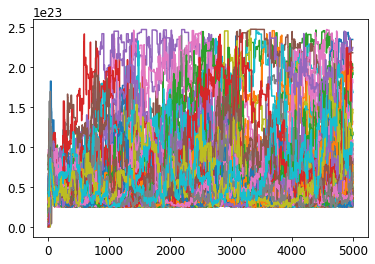

In [62]:
# plt.figure()
# for i in range(100):
#     plt.plot(samples[i,:,3])
    
# print(samples.shape)

In [6]:
# idx = np.where((samples[:,0,2] > 3e-41) & (samples[:,0,2] < 5.5e-41))
# idx = np.ravel(idx)
# samples_ = samples[idx,:,:]
# print(samples_.shape)

# plt.figure()
# for i in range(samples_.shape[0]):
#     plt.plot(samples_[i,:,4])

In [7]:
# #samples_ = np.array(samples)

# ndim=samples_.shape[2]
# samples_reshape = samples_.reshape((-1, ndim))
# print(samples_reshape.shape)

# samples_reshape = np.log10(samples_reshape)


In [8]:
# fig = corner.corner(samples_reshape, labels=["log($R_{disk})$","log($h_{disk})$","log($j_{disk})$",
#                                              "log($R_{halo}$)","log($j_{halo})$"
#                                             ],
#                     label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 16, "position":(0.65,1)},
#                     quantiles=[0.16,0.5,0.84])

# for ax in fig.get_axes(): 
#       ax.tick_params(axis='both', labelsize=12)
        
        
# #plt.savefig('notes/corner_TRIS_spheroids+mask.jpg', bbox_inches = "tight")

# # labels=["log($R_{disk})$","log($h_{disk})$","$log(j_{disk})$","$a_{disk}$","log($R_{halo})$","$log(j_{halo})$","$a_{halo}$"]

0.6 GHz with Disk Model
LogProb: -40.434799
BIC: 100.019566
0.82 GHz with Disk Model
LogProb: -30.120370
BIC: 79.390707
0.6 GHz with Disk + Halo Model
LogProb: -147.486416
BIC: 323.697783
0.82 GHz with Disk + Halo Model
LogProb: -101.406177
BIC: 231.537304


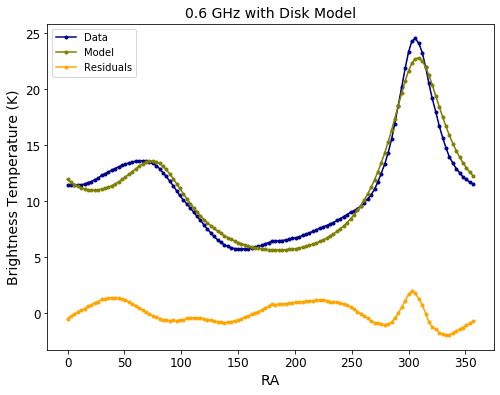

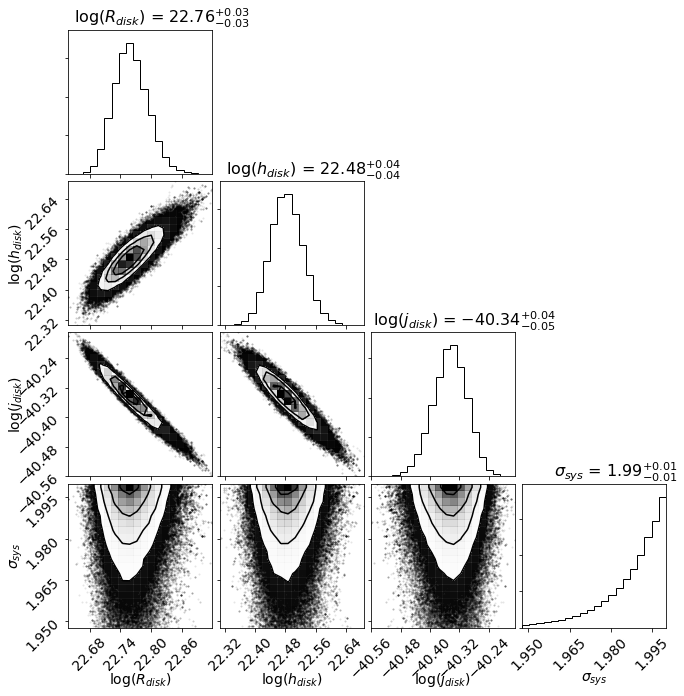

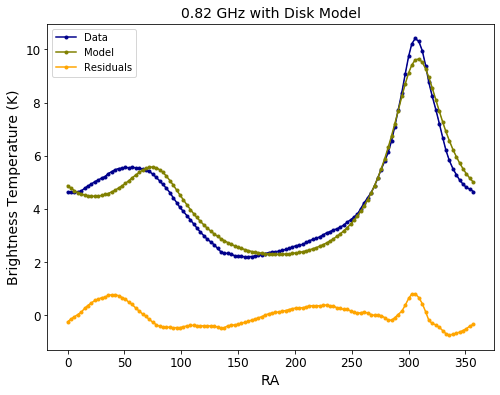

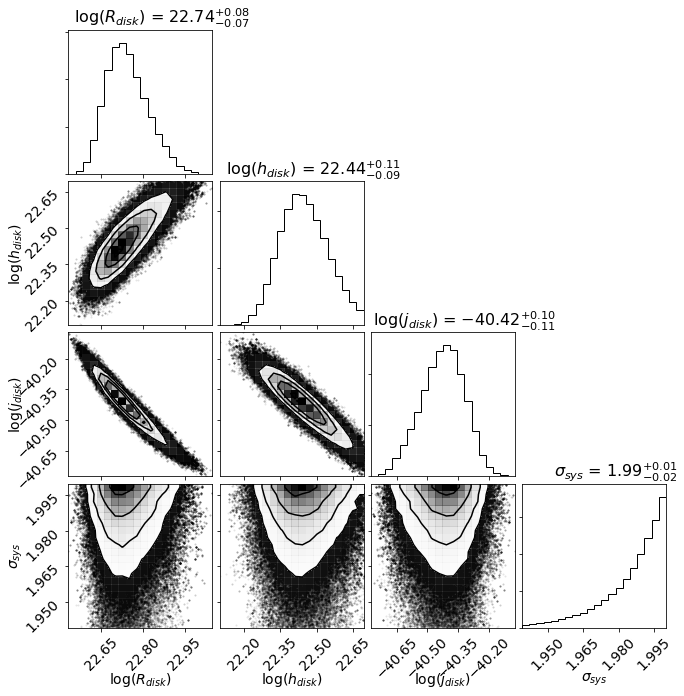

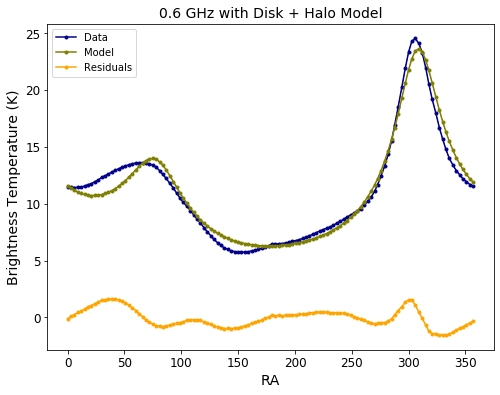

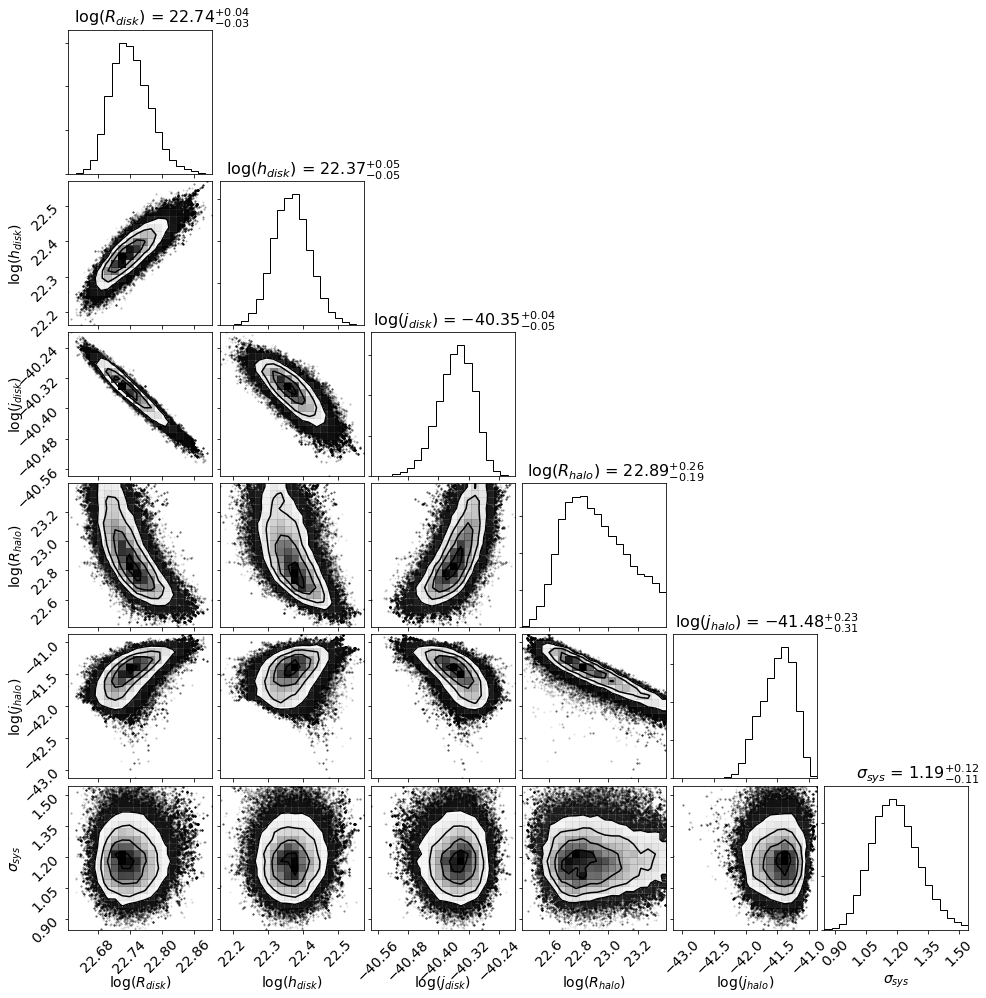

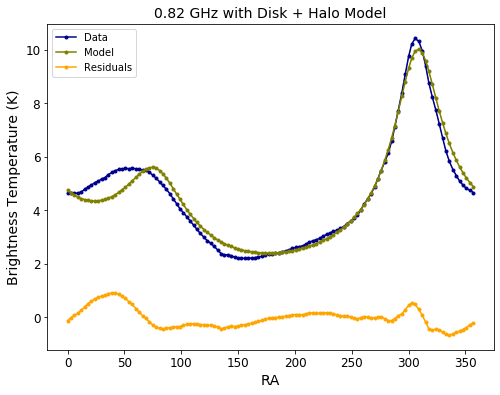

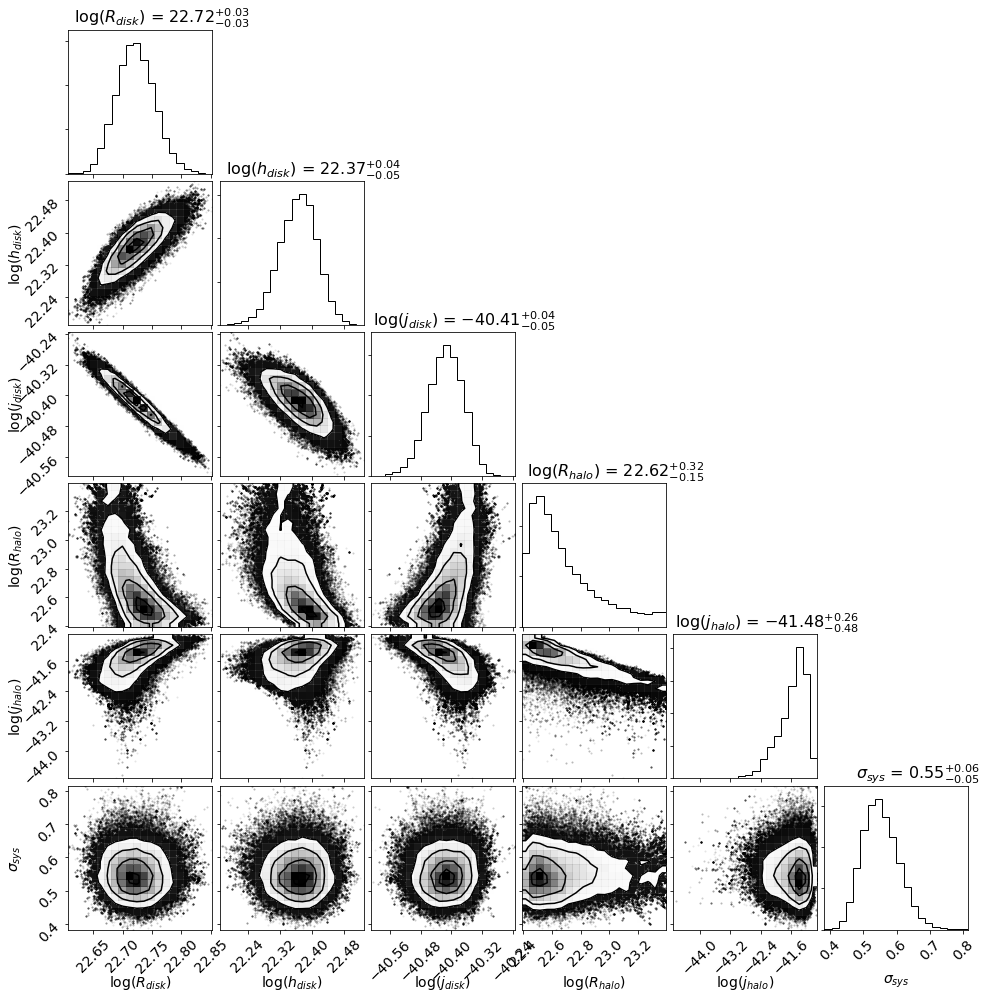

In [47]:
# Stack vertically
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
# fig.suptitle('Test', fontsize=30)
# fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center',fontsize=30)
# fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical',fontsize=30)

for i in range(len(samps)):
    
    s = samps[i]
    dim = -1
    #print(s[:,dim].shape)
    sig = np.std(s[:,dim])
    mn = np.mean(s[:,dim])
    sig3 = np.where((s[:,dim] > mn-3*sig) & (s[:,dim] < mn+3*sig))
    s = s[sig3,:][0]
    
    if i%2 == 0:
        nu = 0.6e9
    else: 
        nu = 0.82e9
        
    if s.shape[1] == 4:
        R_disk = 10**np.percentile(s[:,0], 50)
        h_disk = 10**np.percentile(s[:,1], 50)
        j_disk = 10**np.percentile(s[:,2], 50)
        err_sys = np.percentile(s[:,3], 50)
        
        disk = MD.Spheroid(TRIS_l[nu], TRIS_b[nu], R_disk, h_disk)*j_disk
        model = (disk)*(c**2)/(2*k*(nu**2)) 

        residuals = TRIS_Tgal[nu] - model
        
        t = 'Disk'
        
        lp = LP.disk_TRIS([R_disk,h_disk,j_disk,err_sys],nu)
        
        label_params = ["log($R_{disk})$","log($h_{disk})$","log($j_{disk})$", '$\sigma_{sys}$'
                                            ]
        
    if s.shape[1] == 6:
        R_disk = 10**np.percentile(s[:,0], 50)
        h_disk = 10**np.percentile(s[:,1], 50)
        j_disk = 10**np.percentile(s[:,2], 50)
        R_halo = 10**np.percentile(s[:,3], 50)
        j_halo = 10**np.percentile(s[:,4], 50)
        err_sys = np.percentile(s[:,5], 50)
        
        disk = MD.Spheroid(TRIS_l[nu], TRIS_b[nu], R_disk, h_disk)*j_disk
        halo = MD.LineOfSightHalo(TRIS_l[nu], TRIS_b[nu], d, R_halo)*j_halo

        model = (disk+halo)*(c**2)/(2*k*(nu**2)) 

        residuals = TRIS_Tgal[nu] - model
        
        t = 'Disk + Halo'
        
        lp = LP.diskhalo_TRIS([R_disk,h_disk,j_disk,R_halo,j_halo, err_sys],nu)
        
        label_params = ["log($R_{disk})$","log($h_{disk})$","log($j_{disk})$",
                                             "log($R_{halo}$)","log($j_{halo})$", '$\sigma_{sys}$'
                                            ]
        
    
    plt.figure(2*i,figsize=(8,6))
    plt.plot(TRIS_ra[nu], TRIS_Tgal[nu], 'darkblue', linestyle='-', linewidth='0.5')
    plt.plot(TRIS_ra[nu], TRIS_Tgal[nu],'darkblue', marker='.', label='Data')
    plt.plot(TRIS_ra[nu], model, 'olive', linestyle='-', linewidth='0.5')
    plt.plot(TRIS_ra[nu], model, 'olive', marker='.',label='Model')
    plt.plot(TRIS_ra[nu], residuals,'orange', linestyle='-', linewidth='0.5')
    plt.plot(TRIS_ra[nu], residuals, 'orange', marker='.', label='Residuals')
    plt.title('%s GHz with %s Model'%(str(nu/1e9), t), fontsize=14)
    plt.legend(loc='upper left')
    plt.xlabel('RA', fontsize=14)
    plt.ylabel('Brightness Temperature (K)', fontsize=14)
    plt.savefig('/home/nitikayad96/GradSchool/Classes/Ge117/%s%s_Data.png'%(str(int(nu/1e6)), t), bbox_inches='tight')
    
    
    fig = corner.corner(s, labels=label_params,
                    label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 16, "position":(0.65,1)},
                    quantiles=[])

    for ax in fig.get_axes(): 
          ax.tick_params(axis='both', labelsize=14)
            
    plt.savefig('%s%s_Corner.png'%(str(int(nu/1e6)), t), bbox_inches='tight')
    
    BIC = s.shape[1]*np.log(len(TRIS_Tgal[nu])) - 2*lp
            
    print('%s GHz with %s Model'%(str(nu/1e9), t))
    print('LogProb: %f' %lp)
    print('BIC: %f' %BIC)
